# Neural Style transfer

This notebook presents my implementation of the neural style transfer algorithm from
[Gatys *et al.* (2015)](https://arxiv.org/abs/1508.06576). Some implementation details may differ if compared with the authors' code.

First, let us load the required packages for this code:

In [1]:
# Core packages
import itertools
import os

# 3rd-party packages
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm

# Local packages
import utils
from model import StyleTransferer

Load and format content and style images, then, store all possible combinations
between both groups in a list of tuples:

In [2]:
# Create list with names of the image files to be loaded
content_fnames = [f'content images/content{i}.jpg' for i in [1, 2, 3]]
style_fnames = [f'style images/style{i}.jpg' for i in [1, 2]]

# Loop over all combinations of content and style images
images = []
combinations = list(itertools.product(content_fnames, style_fnames))
for content_fname, style_fname in tqdm(combinations):

    # Define how to crop content images
    if content_fname == 'content images/content1.jpg':
        reshape_as = [0, 2550, 0, 2550]
    elif content_fname == 'content images/content2.jpg':
        reshape_as = [0, 720, 200, 920]
    else:
        reshape_as = [0, 1600, 0, 1600]

    # Load and format content images
    content_orig = plt.imread(content_fname)
    content_crop = utils.reshape_img(content_orig, reshape_as, [256, 256])
    content = utils.img_to_input(content_crop)

    # Define how to crop style images
    if style_fname == 'style images/style1.jpg':
        reshape_as = [100, 835, 0, 735]
    else:
        reshape_as = [0, 675, 525, 1200]

    # Load and format style images
    style_orig = plt.imread(style_fname)
    style_crop = utils.reshape_img(style_orig, reshape_as, [256, 256])
    style = utils.img_to_input(style_crop)

    # Store image combinations in one list of tuples (pair: content, styple)
    images.append((content, style))

Display loaded images:

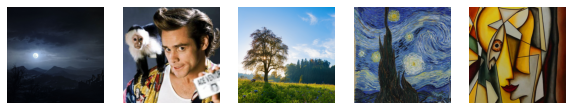

In [3]:
images_to_plot = {
    'Content 1': images[0][0],
    'Content 2': images[2][0],
    'Content 3': images[4][0],
    'Style 1': images[0][1],
    'Style 2': images[1][1]
}

plt.figure(figsize=(10, 20))
for idx, (key, val) in enumerate(images_to_plot.items(), 1):
    plt.subplot(1, 5, idx)
    plt.imshow(utils.input_to_img(val))
    plt.box(False)
    plt.tick_params(labelbottom=False, labelleft=False, length=0);

Load the VGG19 neural network architecture trained with the ImageNet dataset:

In [4]:
vgg19 = tf.keras.applications.VGG19
vgg19 = vgg19(include_top=False, input_shape=style_crop.shape)

Transfer style from style images to content images, using all possible combinations:

In [5]:
generated_images = []
for content, style in tqdm(images):
    transferer = StyleTransferer(
        base_model=vgg19,
        content_image=content,
        style_image=style,
        content_layer='block5_conv2',
        style_layers=['block1_conv1', 'block2_conv1', 'block3_conv1',
                      'block4_conv1', 'block5_conv1'],
        style_weights=[1, 1, 1, 1, 1]
    )
    opt = tf.optimizers.Adam(learning_rate=5)
    transferer.transform(1000, 1e-4, 1, opt)
    generated_image = utils.input_to_img(transferer.generated_image)
    generated_images.append(generated_image)

Display generated images:

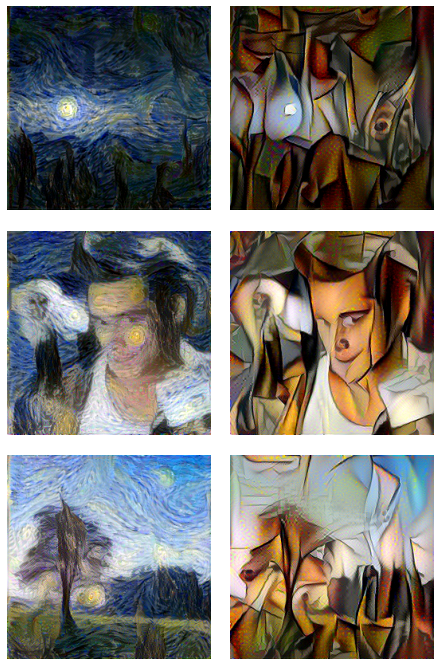

In [6]:
plt.figure(figsize=(8, 12))
for idx in range(1, 7):
    plt.subplot(3, 2, idx)
    plt.imshow(generated_images[idx - 1])
    plt.box(False)
    plt.tick_params(labelbottom=False, labelleft=False, length=0)
plt.subplots_adjust(wspace=0, hspace=0.1)

Save generated files to disk:

In [7]:
if not os.path.exists('generated images'):
    os.makedirs('generated images')

counter = 0
for idx_content in range(1, 4):
    for idx_style in range(1, 3):
        fname = f'generated images/from_{idx_style}_to_{idx_content}.jpg'
        plt.imsave(fname, generated_images[counter])
        counter += 1